# Bennets Hipathia Scriptt

## 1. Instalation & Setup

In [1]:
# --- Install 'dplyr' if missing ---
if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}

## Install BiocManager only if missing
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

## Set Bioconductor version COMPATIBLE with R 4.3.x
BiocManager::install(version = "3.18")

## Install edgeR from Bioconductor 3.18
BiocManager::install("edgeR")

# --- Load core libraries ---
library(dplyr)
library(hipathia)
library(data.table)
library(matrixStats)
# --- Check installed versions (optional but useful for documentation) ---
packageVersion("hipathia")
packageVersion("dplyr")

## ==========================
## Pakete
## ==========================
library(data.table)    # schnelles IO + Aggregation
library(matrixStats)   # schnelle rowVars / rowSds
# Optional, aber stark empfohlen für große PCA:
use_irlba <- TRUE
if (use_irlba) {
  if (!requireNamespace("irlba", quietly = TRUE)) {
    install.packages("irlba")
  }
  library(irlba)
}



'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.27), R 4.3.3 (2024-02-29)

Old packages: 'blob', 'broom', 'clock', 'data.table', 'doBy', 'e1071',
  'future', 'future.apply', 'ggsci', 'htmltools', 'igraph', 'isoband', 'knitr',
  'later', 'lifecycle', 'lme4', 'parallelly', 'proxy', 'purrr', 'rappdirs',
  'Rcpp', 'RcppArmadillo', 'reformulas', 'rlang', 'RSQLite', 'rstudioapi',
  'selectr', 'shiny', 'sparsevctrs', 'survival', 'tibble', 'tidyr', 'vctrs',
  'vroom', 'xfun', 'xml2', 'yaml', 'zoo'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.27), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when

[1] ‘3.2.0’

[1] ‘1.1.4’

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand




## 2. Parameters

### 2.1 Set Paramter 

In [2]:
# ---- Input files ----
rna_path  <- "RNA_filtered_by_patient7,13,786.csv"        # raw RNA matrix: Genes × Cells
meta_path <- "complet_cell_metadata_grouped.csv"   # metadata with cell_id + celltype info

# ---- Output files ----
rna_standardized_out <- "rna_standardized.csv"

# Column in metadata that contains celltype annotation
group_column <- "celltype"
# ---- DEFINE GROUPS YOU WANT TO COMPARE ----
group1_name  <- "Normal"        # name in output (left in Hipathia)
group2_name  <- "Tumor"        # name in output (right in Hipathia)
# Which celltypes belong to each group?
group1_types <- c("Mesothelium")     # OR: c("CD4 T_cells")Mesothelium
group2_types <- c("Malignant")       # OR: c("CD8 T_cells")

# 2.3 Sample ID to inspect for celltype composition
inspect_sample <- "p4"

# Combined list of valid groups
allowed_groups <- c(group1_types, group2_types)

# ---- Options ----
min_overlap_prop  <- 0.9
min_cells     <- 30

# ---- Hipathia ----
species       <- "hsa"
pathways_list <- c()   # empty = load all pathways





## 3. Patient Filter &Metadata Processing

### 3.1 Load metadata & basic preprocessing


In [3]:
meta <- fread(meta_path, data.table = FALSE)

# Check auf notwendige Spalten
stopifnot(all(c("cell_id", "orig.ident", group_column) %in% colnames(meta)))

# Patient-ID: pXXXpos / pXXXneg -> pXXX
meta$patient_id <- gsub("pos|neg", "", meta$orig.ident)

# Nur relevante Celltypes behalten
meta_filt <- meta[meta[[group_column]] %in% allowed_groups, , drop = FALSE]

### 3.2 Patient filtering based on cell-type abundance


In [4]:
# Zellzahlen pro Patient × Celltype
cell_counts <- with(
  meta_filt,
  table(patient_id, .subset2(meta_filt, group_column))
)

# Summen für group1 / group2
group1_counts <- rowSums(cell_counts[, group1_types, drop = FALSE])
group2_counts <- rowSums(cell_counts[, group2_types, drop = FALSE])

# Patienten, die genug Zellen von BEIDEN Gruppen haben
valid_patients <- names(which(group1_counts >= min_cells & group2_counts >= min_cells))
if (length(valid_patients) == 0) {
  stop("Kein Patient erfüllt min_cells-Kriterium für beide Gruppen.")
}

## Diagnose-Tabelle (falls du sie brauchst)
patients <- rownames(cell_counts)
rows <- c(
  paste0('group1_name = "', group1_name, '"'),
  group1_types,
  paste0('group2_name = "', group2_name, '"'),
  group2_types,
  "keep"
)

diagnosis_matrix <- matrix(
  "",
  nrow = length(rows),
  ncol = length(patients),
  dimnames = list(rows, patients)
)

### 3.3 Diagnostic table & final metadata assembly


In [5]:

# Summen für group1 / group2
diagnosis_matrix[paste0('group1_name = "', group1_name, '"'), ] <- as.numeric(group1_counts[patients])
diagnosis_matrix[paste0('group2_name = "', group2_name, '"'), ] <- as.numeric(group2_counts[patients])

# Einzelne Celltypes
for (ct in group1_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[patients, ct])
}
for (ct in group2_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[patients, ct])
}

diagnosis_matrix["keep", ] <- ifelse(
  group1_counts[patients] >= min_cells & group2_counts[patients] >= min_cells,
  "TRUE", "FALSE"
)

diagnosis_table <- as.data.frame(diagnosis_matrix, stringsAsFactors = FALSE)
print(diagnosis_table)

cat("\n===== PATIENT FILTERING DONE =====\n")
cat("Comparison: ", group1_name, " vs ", group2_name, "\n", sep = "")
cat("Min cells per group required: ", min_cells, "\n", sep = "")
cat("Patients passing filter: ", paste(valid_patients, collapse = ", "), "\n\n", sep = "")

# Finales Metadata nur mit validen Patienten
meta_final <- meta_filt[meta_filt$patient_id %in% valid_patients, , drop = FALSE]

# Normal/Tumor Label
meta_final$group <- ifelse(
  meta_final[[group_column]] %in% group1_types,
  group1_name,
  group2_name
)

# Barcodes, die nach Filter übrig sind
filtered_barcodes <- unique(meta_final$cell_id)
if (length(filtered_barcodes) == 0) {
  stop("Patient filter produced zero remaining cell barcodes.")
}
message("Number of remaining barcodes after filtering: ", length(filtered_barcodes))


                         p11   p12  p13   p4    p7 p786    p8  p811  p826  p846
group1_name = "Normal"     0     0   32   58     0  286     0     0     0     0
Mesothelium                0     0   32   58     0  286     0     0     0     0
group2_name = "Tumor"   1021  1143  116  330  2280  174  5672 11618  4109    97
Malignant               1021  1143  116  330  2280  174  5672 11618  4109    97
keep                   FALSE FALSE TRUE TRUE FALSE TRUE FALSE FALSE FALSE FALSE
                        p848    p9
group1_name = "Normal"     0     0
Mesothelium                0     0
group2_name = "Tumor"   3551   207
Malignant               3551   207
keep                   FALSE FALSE

===== PATIENT FILTERING DONE =====
Comparison: Normal vs Tumor
Min cells per group required: 30
Patients passing filter: p13, p4, p786



Number of remaining barcodes after filtering: 996



## 4. RNA Reader & Standardisation

### 4.1 Helper functions

In [6]:
# kleines Trim-Utility
trim_all <- function(df) {
  names(df) <- trimws(names(df))
  for (i in seq_along(df)) {
    if (is.character(df[[i]])) {
      df[[i]] <- trimws(df[[i]])
    }
  }
  df
}

looks_gene_symbol <- function(v) {
  v <- trimws(as.character(v))
  non_na <- v[!is.na(v)]
  if (length(non_na) == 0) return(FALSE)

  mean(grepl("[A-Za-z]", non_na)) > 0.5 &&
    mean(nchar(non_na) < 20) > 0.95 &&
    mean(grepl("-", non_na)) < 0.5 &&
    mean(grepl("^\\d+$", non_na)) < 0.1
}



### 4.2. Read RNA File

In [7]:
rna_raw <- fread(rna_path, data.table = FALSE)
rna_raw <- trim_all(rna_raw)

# Gene-Spalte finden
gene_name_hits <- which(tolower(colnames(rna_raw)) %in% c("gene", "genes", "symbol", "geneid"))

if (length(gene_name_hits) == 1) {
  gene_col <- gene_name_hits
} else {
  first_col <- rna_raw[[1]]
  if (looks_gene_symbol(head(first_col, 200))) {
    gene_col <- 1
  } else {
    cand <- which(sapply(rna_raw, function(col) looks_gene_symbol(head(col, 200))))
    gene_col <- cand[1]
  }
}

if (is.na(gene_col) || length(gene_col) == 0) {
  stop("Could not detect gene column.")
}

colnames(rna_raw)[gene_col] <- "Gene"

### 4.4. Standardization RNA Matrix

In [8]:
rna_barcodes   <- setdiff(colnames(rna_raw), "Gene")
keep_barcodes  <- intersect(rna_barcodes, filtered_barcodes)

message("Keeping ", length(keep_barcodes), " barcodes after patient filtering.")

if (length(keep_barcodes) == 0) {
  stop("No overlapping barcodes between RNA and filtered metadata.")
}

# Nur Gene + benötigte Barcodes
rna <- rna_raw[, c("Gene", keep_barcodes), drop = FALSE]

# Numeric-Konvertierung vektorisiert
rna[, keep_barcodes] <- lapply(rna[, keep_barcodes, drop = FALSE], function(x) {
  x <- trimws(as.character(x))
  x[x == ""] <- NA
  suppressWarnings(as.numeric(x))
})

# Leere Gene droppen
rna$Gene <- trimws(as.character(rna$Gene))
rna <- rna[rna$Gene != "" & !is.na(rna$Gene), , drop = FALSE]

# Duplikate effizient mit data.table collapsen
if (anyDuplicated(rna$Gene)) {
  message("Duplicate genes detected → collapsing by sum (data.table).")
  dt <- as.data.table(rna)
  rna_dt <- dt[, lapply(.SD, sum, na.rm = TRUE), by = Gene]
  setcolorder(rna_dt, c("Gene", keep_barcodes))
  rna <- as.data.frame(rna_dt)
}

# Export
write.csv(rna, rna_standardized_out, row.names = FALSE)
message("Wrote standardized RNA: ", ncol(rna) - 1, " barcodes kept.")


Keeping 996 barcodes after patient filtering.

Wrote standardized RNA: 996 barcodes kept.



## 5. PCA befor and after Patient filter

### 5.1. PCA utility function (variance filtering)

In [9]:
run_pca <- function(mat, n_pc = 20) {
  # Gene mit Varianz > 0
  vars <- rowVars(mat, useNames = FALSE, na.rm = TRUE)
  mat2 <- mat[vars > 0, , drop = FALSE]

  if (use_irlba) {
    irlba::prcomp_irlba(t(mat2), n = n_pc, center = TRUE, scale. = TRUE)
  } else {
    prcomp(t(mat2), scale. = TRUE)
  }
}


### 5.2. PCA before Patient Filter

### 5.3. PCA after Patient Filter

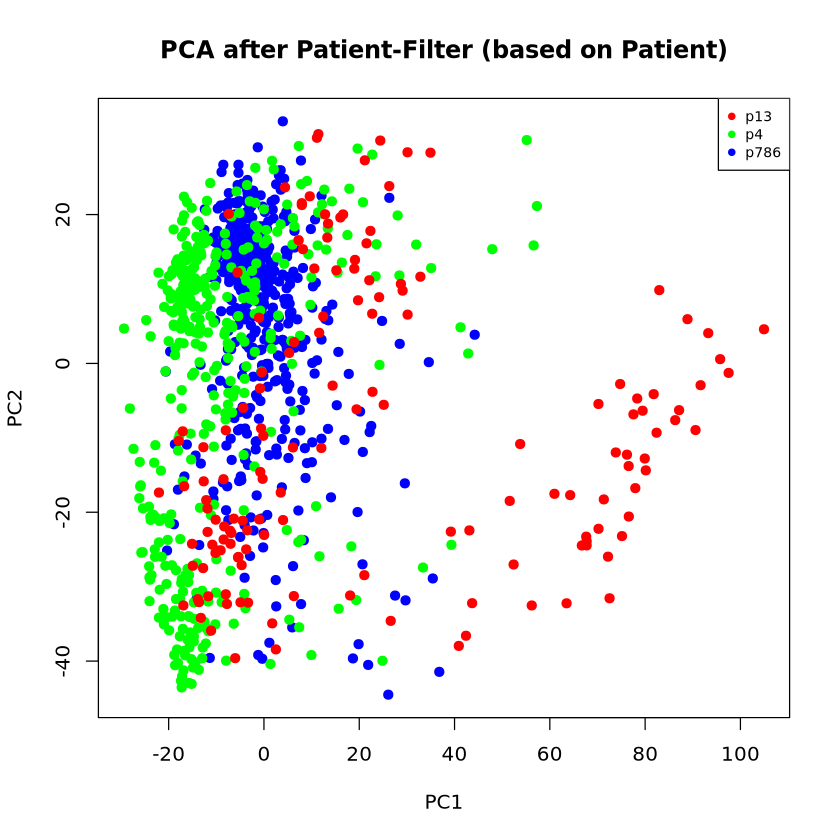

In [10]:

filt_barcodes <- keep_barcodes
pca_filt_mat <- as.matrix(rna[, filt_barcodes, drop = FALSE])
pca_filt <- run_pca(pca_filt_mat, n_pc = 10)

filt_meta <- meta_final[match(filt_barcodes, meta_final$cell_id), ]
patient_filt <- factor(filt_meta$patient_id)
pal_filt <- rainbow(length(levels(patient_filt)))
cols_filt <- pal_filt[patient_filt]

plot(
  pca_filt$x[, 1], pca_filt$x[, 2],
  xlab = "PC1", ylab = "PC2",
  main = "PCA after Patient-Filter (based on Patient)",
  pch = 19, col = cols_filt
)
legend("topright", legend = levels(patient_filt), col = pal_filt, pch = 19, cex = 0.7)


## Check

### 5.1. Check: cells per patient X


In [11]:
## ==========================
## Inspect patient cell composition
## ==========================

cat("\n===== Inspecting patient:", inspect_sample, "=====\n")

# Direkter Filter
meta_inspect <- meta[meta$orig.ident == inspect_sample, , drop = FALSE]

if (nrow(meta_inspect) == 0) {
  stop("No cells found for patient: ", inspect_sample)
}

# Liste der einzigartigen Zelltypen
unique_celltypes_inspect <- unique(meta_inspect[[group_column]])
cat("\nUnique cell types for patient", inspect_sample, ":\n")
print(unique_celltypes_inspect)

# Counts pro Celltype
celltype_counts <- table(meta_inspect[[group_column]])
cat("\nCell counts for patient", inspect_sample, ":\n")
print(celltype_counts)

cat("\n===== End inspection for:", inspect_sample, "=====\n\n")



===== Inspecting patient: p4 =====

Unique cell types for patient p4 :
 [1] "TAMs"          "Malignant"     "Mono_CD16"     "CD8"          
 [5] "cDC2"          "KLRC1_NK"      "CD4"           "Mono_CD14"    
 [9] "B_cells"       "Fibroblasts"   "Mesothelium"   "TFH"          
[13] "FGFBP2_NK"     "pDC"           "Tregs"         "Plasma"       
[17] "cDC1"          "SmoothMuscle"  "NKlike_Tcells" "Mast"         
[21] "Vein"          "mregDC"        "PLVAP"        

Cell counts for patient p4 :

      B_cells           CD4           CD8          cDC1          cDC2 
           42           350           218            34           197 
    FGFBP2_NK   Fibroblasts      KLRC1_NK     Malignant          Mast 
           20           199           213           330             3 
  Mesothelium     Mono_CD14     Mono_CD16        mregDC NKlike_Tcells 
           58           495           109             2             4 
          pDC        Plasma         PLVAP  SmoothMuscle          TAMs 
  

### 5.2. Check: Barcode Overlap AFTER standardization

In [12]:
meta_ids <- unique(meta_final$cell_id)
rna_ids  <- setdiff(colnames(rna), "Gene")

overlap <- intersect(meta_ids, rna_ids)

prop_rna  <- length(overlap) / length(rna_ids)   # Wie viel % der RNA sind in meta?
prop_meta <- length(overlap) / length(meta_ids)  # Wie viel % der meta_final haben RNA?

cat("\n===== BARCODE OVERLAP CHECK =====\n")
cat("RNA barcodes:        ", length(rna_ids), "\n")
cat("Meta barcodes:       ", length(meta_ids), "\n")
cat("Overlap:             ", length(overlap), "\n")
cat(sprintf("Coverage RNA  -> meta:  %.1f%%\n", 100 * prop_rna))
cat(sprintf("Coverage meta -> RNA:   %.1f%%\n", 100 * prop_meta))

# WIRKLICH WICHTIG:
if (prop_rna < 0.99) {
  warning("Nicht alle RNA-Barcodes haben passende Metadata – DAS ist ein echtes Problem.")
} else {
  message("Alle (oder fast alle) RNA-Barcodes sind in den Metadaten vertreten. ✔")
}



===== BARCODE OVERLAP CHECK =====
RNA barcodes:         996 
Meta barcodes:        996 
Overlap:              996 
Coverage RNA  -> meta:  100.0%
Coverage meta -> RNA:   100.0%


Alle (oder fast alle) RNA-Barcodes sind in den Metadaten vertreten. ✔



In [13]:
# 1. Number of barcodes in the original RNA matrix
original_rna_barcodes <- setdiff(colnames(rna_raw), "Gene")
message("Original RNA barcodes: ", length(original_rna_barcodes))

# 2. Number of barcodes after metadata filtering
message("Filtered (kept) barcodes in metadata: ", length(filtered_barcodes))

# 3. How many barcodes match between RNA and metadata?
meta_barcodes <- meta_final$cell_id
message("Overlap (RNA ∩ metadata): ",
        length(intersect(original_rna_barcodes, meta_barcodes)))

# 4. Which RNA barcodes were NOT kept by the patient filter?
lost <- setdiff(original_rna_barcodes, filtered_barcodes)
message("RNA barcodes discarded by patient filter: ", length(lost))
if (length(lost) > 0) print(head(lost, 20))




Original RNA barcodes: 21085

Filtered (kept) barcodes in metadata: 996

Overlap (RNA ∩ metadata): 996

RNA barcodes discarded by patient filter: 20089



 [1] "p786pos_AAACCCAAGTTGGAAT-1" "p786pos_AAACCCACAAACACCT-1"
 [3] "p786pos_AAACCCATCCACATAG-1" "p786pos_AAACGAACACATACGT-1"
 [5] "p786pos_AAACGAACAGCTGGTC-1" "p786pos_AAACGAAGTGTGAGCA-1"
 [7] "p786pos_AAACGCTGTATCACGT-1" "p786pos_AAACGCTTCAGGGTAG-1"
 [9] "p786pos_AAAGAACAGTGCAGGT-1" "p786pos_AAAGGATGTCCCTGAG-1"
[11] "p786pos_AAAGGATTCTCTATGT-1" "p786pos_AAAGGATTCTTCCCAG-1"
[13] "p786pos_AAAGGGCCAAGCCCAC-1" "p786pos_AAAGGGCTCCCATACC-1"
[15] "p786pos_AAAGGTAAGCATGCAG-1" "p786pos_AAAGGTACAATGGCAG-1"
[17] "p786pos_AAAGGTACACTCGATA-1" "p786pos_AAAGGTAGTAGTGGCA-1"
[19] "p786pos_AAAGGTAGTGGAATGC-1" "p786pos_AAAGGTATCAGCAATC-1"


## 6. Cell-level Matrix + scRNA-Normalisation

In [14]:


message("\n===== BUILDING CELL-LEVEL MATRIX (no pseudobulk) =====")

# --- 1) Barcodes (Zellen) final ---
cell_ids <- intersect(setdiff(colnames(rna), "Gene"), meta_final$cell_id)
stopifnot(length(cell_ids) > 0)

# --- 2) Counts-Matrix: Gene(Symbol) x Zellen ---
mat_counts <- as.matrix(rna[, cell_ids, drop = FALSE])
rownames(mat_counts) <- rna$Gene
storage.mode(mat_counts) <- "numeric"

# --- 3) SYMBOL -> ENTREZ + Duplikate pro Entrez aufsummieren (ID-cleanup) ---
library(org.Hs.eg.db)
library(AnnotationDbi)

entrez <- mapIds(
  org.Hs.eg.db,
  keys = rownames(mat_counts),
  column = "ENTREZID",
  keytype = "SYMBOL",
  multiVals = "first"
)

keep <- !is.na(entrez)
mat_e <- mat_counts[keep, , drop = FALSE]

# rowsum fasst doppelte EntrezIDs zusammen
mat_e <- rowsum(mat_e, group = entrez[keep])

message("Genes (Entrez): ", nrow(mat_e), " | Cells: ", ncol(mat_e))

# --- 4) Sinnige scRNA-Normalisierung: library-size scaling + log1p ---
libsize <- colSums(mat_e)
stopifnot(all(libsize > 0))

# CP1e6 (CPM) + log1p
trans_data <- log1p(t(t(mat_e) / libsize * 1e6))

# --- 5) Zell-Design (Patient + Group pro Zelle) ---
design_cell <- meta_final[match(colnames(trans_data), meta_final$cell_id), ]
design_cell$group <- ifelse(
  design_cell[[group_column]] %in% group1_types,
  group1_name,
  group2_name
)

# Quick sanity check:
print(table(design_cell$patient_id, design_cell$group))

message("===== CELL-LEVEL MATRIX READY =====\n")



===== BUILDING CELL-LEVEL MATRIX (no pseudobulk) =====

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select




'select()' returned 1:many mapping between keys and columns

Genes (Entrez): 22405 | Cells: 996



      
       Normal Tumor
  p13      32   116
  p4       58   330
  p786    286   174


===== CELL-LEVEL MATRIX READY =====




## 7. Patient-level aggregation of pathway activity


### 7.1 Aggregate expression per patient × group (pre-Hipathia)

In [15]:
message("\n===== 7.1 AGGREGATING EXPRESSION PER PATIENT × GROUP =====")

# Preconditions
stopifnot(exists("trans_data"))
stopifnot(exists("design_cell"))
stopifnot(all(colnames(trans_data) == design_cell$cell_id))

# Build patient-group labels per cell (e.g. "p4_Tumor")
pg_label  <- paste0(design_cell$patient_id, "_", design_cell$group)
pg_levels <- unique(pg_label)

# Robust aggregation: median across cells per gene
expr_pg <- sapply(pg_levels, function(g) {
  idx <- pg_label == g
  matrixStats::rowMedians(trans_data[, idx, drop = FALSE], na.rm = TRUE)
})

expr_pg <- as.matrix(expr_pg)
colnames(expr_pg) <- pg_levels

message("expr_pg dimensions: ", nrow(expr_pg), " genes × ", ncol(expr_pg), " patient-group samples")

# Sanity check: each patient should have both groups
pg_patient <- sub("_(.*)$", "", colnames(expr_pg))
pg_group   <- sub("^.*_", "", colnames(expr_pg))
print(table(pg_patient, pg_group))



===== 7.1 AGGREGATING EXPRESSION PER PATIENT × GROUP =====

expr_pg dimensions: 22405 genes × 6 patient-group samples



          pg_group
pg_patient Normal Tumor
      p13       1     1
      p4        1     1
      p786      1     1


### 7.2 Run Hipathia on patient × group expression matrix

In [16]:
message("\n===== 7.2 RUNNING HIPATHIA (PATIENT × GROUP LEVEL) =====")

# Hipathia normalization
exp_data <- hipathia::normalize_data(expr_pg, by_quantiles = FALSE)

# Load pathways
pathways <- if (length(pathways_list) == 0) {
  hipathia::load_pathways(species = species)
} else {
  hipathia::load_pathways(species = species, pathways_list = pathways_list)
}

# Correct pathway count
pw_list <- hipathia::get_pathways_list(pathways)

n_pathways <- if (is.data.frame(pw_list) && "pathway" %in% names(pw_list)) {
  length(unique(pw_list$pathway))
} else if (is.character(pw_list)) {
  length(unique(pw_list))
} else if (is.list(pw_list) && !is.null(names(pw_list))) {
  length(unique(names(pw_list)))
} else if (is.list(pw_list)) {
  length(unique(unlist(pw_list)))
} else {
  NA_integer_
}

message("KEGG pathways loaded (best-effort): ", n_pathways)
# Run Hipathia
results <- hipathia::hipathia(
  exp_data,
  pathways,
  decompose = FALSE,
  verbose = FALSE
)

# Extract subpathway activity
path_vals <- hipathia::get_paths_data(results)
pm <- SummarizedExperiment::assay(path_vals)

stopifnot(all(colnames(pm) == colnames(expr_pg)))
message("Subpathways: ", nrow(pm), " | Samples: ", ncol(pm))



===== 7.2 RUNNING HIPATHIA (PATIENT × GROUP LEVEL) =====

Loaded 146 pathways

KEGG pathways loaded (best-effort): 146

Added missing genes: 55 (0.24%)

Subpathways: 1876 | Samples: 6



### 7.3 Patient-wise deltas and combined consensus

In [17]:
message("\n===== 7.3 BUILDING PATIENT-WISE DELTAS =====")

# Identify paired patients (must have both groups)
patients_normal <- unique(sub("_(.*)$", "", colnames(pm)[grepl(paste0("_", group1_name, "$"), colnames(pm))]))
patients_tumor  <- unique(sub("_(.*)$", "", colnames(pm)[grepl(paste0("_", group2_name, "$"), colnames(pm))]))

paired_patients <- intersect(patients_normal, patients_tumor)
stopifnot(length(paired_patients) > 0)

message("Paired patients: ", paste(paired_patients, collapse = ", "))

# Delta per patient: Tumor - Normal
delta_mat <- sapply(paired_patients, function(p) {
  pm[, paste0(p, "_", group2_name)] -
    pm[, paste0(p, "_", group1_name)]
})

delta_mat <- as.matrix(delta_mat)
rownames(delta_mat) <- rownames(pm)
colnames(delta_mat) <- paired_patients

message("delta_mat dimensions: ", nrow(delta_mat), " subpathways × ", ncol(delta_mat), " patients")

# Combined effect: equal patient weight (robust)
combined_effect <- matrixStats::rowMedians(delta_mat, na.rm = TRUE)

# Direction
combined_direction <- ifelse(combined_effect >= 0, "UP", "DOWN")

# Direction consistency (important at n=3)
n_up <- rowSums(delta_mat > 0, na.rm = TRUE)
n_dn <- rowSums(delta_mat < 0, na.rm = TRUE)

consistency <- ifelse(n_up == ncol(delta_mat), "UP_all",
               ifelse(n_dn == ncol(delta_mat), "DOWN_all",
               ifelse(n_up >= ceiling(ncol(delta_mat) * 2/3), "UP_majority",
               ifelse(n_dn >= ceiling(ncol(delta_mat) * 2/3), "DOWN_majority", "mixed"))))

# Ranked summary table
rank_combined <- data.frame(
  subpathway = rownames(delta_mat),
  combined_effect = combined_effect,
  abs_effect = abs(combined_effect),
  direction = combined_direction,
  consistency = consistency,
  stringsAsFactors = FALSE
)

rank_combined <- rank_combined[order(rank_combined$abs_effect, decreasing = TRUE), ]
message("Top combined subpathways by absolute effect:")
print(head(rank_combined, 10))



===== 7.3 BUILDING PATIENT-WISE DELTAS =====

Paired patients: p786, p4, p13

delta_mat dimensions: 1876 subpathways × 3 patients

Top combined subpathways by absolute effect:



                       subpathway combined_effect abs_effect direction
P-hsa04610-44       P-hsa04610-44      -0.8017846  0.8017846      DOWN
P-hsa04670-86       P-hsa04670-86      -0.7199054  0.7199054      DOWN
P-hsa05014-49       P-hsa05014-49      -0.5819248  0.5819248      DOWN
P-hsa04520-44 47 P-hsa04520-44 47      -0.5718095  0.5718095      DOWN
P-hsa05205-422     P-hsa05205-422      -0.5300836  0.5300836      DOWN
P-hsa05133-73       P-hsa05133-73      -0.4949262  0.4949262      DOWN
P-hsa05205-352     P-hsa05205-352      -0.4940984  0.4940984      DOWN
P-hsa05132-13       P-hsa05132-13      -0.4869112  0.4869112      DOWN
P-hsa04310-22       P-hsa04310-22      -0.4722034  0.4722034      DOWN
P-hsa04152-38       P-hsa04152-38      -0.4668175  0.4668175      DOWN
                   consistency
P-hsa04610-44         DOWN_all
P-hsa04670-86         DOWN_all
P-hsa05014-49    DOWN_majority
P-hsa04520-44 47      DOWN_all
P-hsa05205-422   DOWN_majority
P-hsa05133-73         DOWN_all
P-

In [18]:
## ============================================================
## 7.4 Build Hipathia-compatible comp objects
## ============================================================

make_comp_from_effect <- function(effect_vec) {
  stopifnot(!is.null(names(effect_vec)))
  comp <- data.frame(
    p.value = rep(1, length(effect_vec)),
    FDRp.value = rep(1, length(effect_vec)),
    stringsAsFactors = FALSE,
    row.names = names(effect_vec)
  )
  comp$`UP/DOWN` <- ifelse(effect_vec >= 0, "UP", "DOWN")
  comp
}

# Per-patient comp objects
comp_by_patient <- lapply(paired_patients, function(p) {
  eff <- delta_mat[, p]
  names(eff) <- rownames(delta_mat)
  make_comp_from_effect(eff)
})
names(comp_by_patient) <- paired_patients

# Combined comp object
eff_comb <- combined_effect
names(eff_comb) <- rownames(delta_mat)
comp_combined <- make_comp_from_effect(eff_comb)

message("===== STEP 7 COMPLETE =====")


===== STEP 7 COMPLETE =====



In [19]:
paired_patients


[1] "p786" "p4"   "p13"


===== 7.5 SHOWING PATIENT-SPECIFIC COMPARISON PLOTS (JUPYTER) =====

Visualizing pathway: hsa03320

Plotting patient: p786



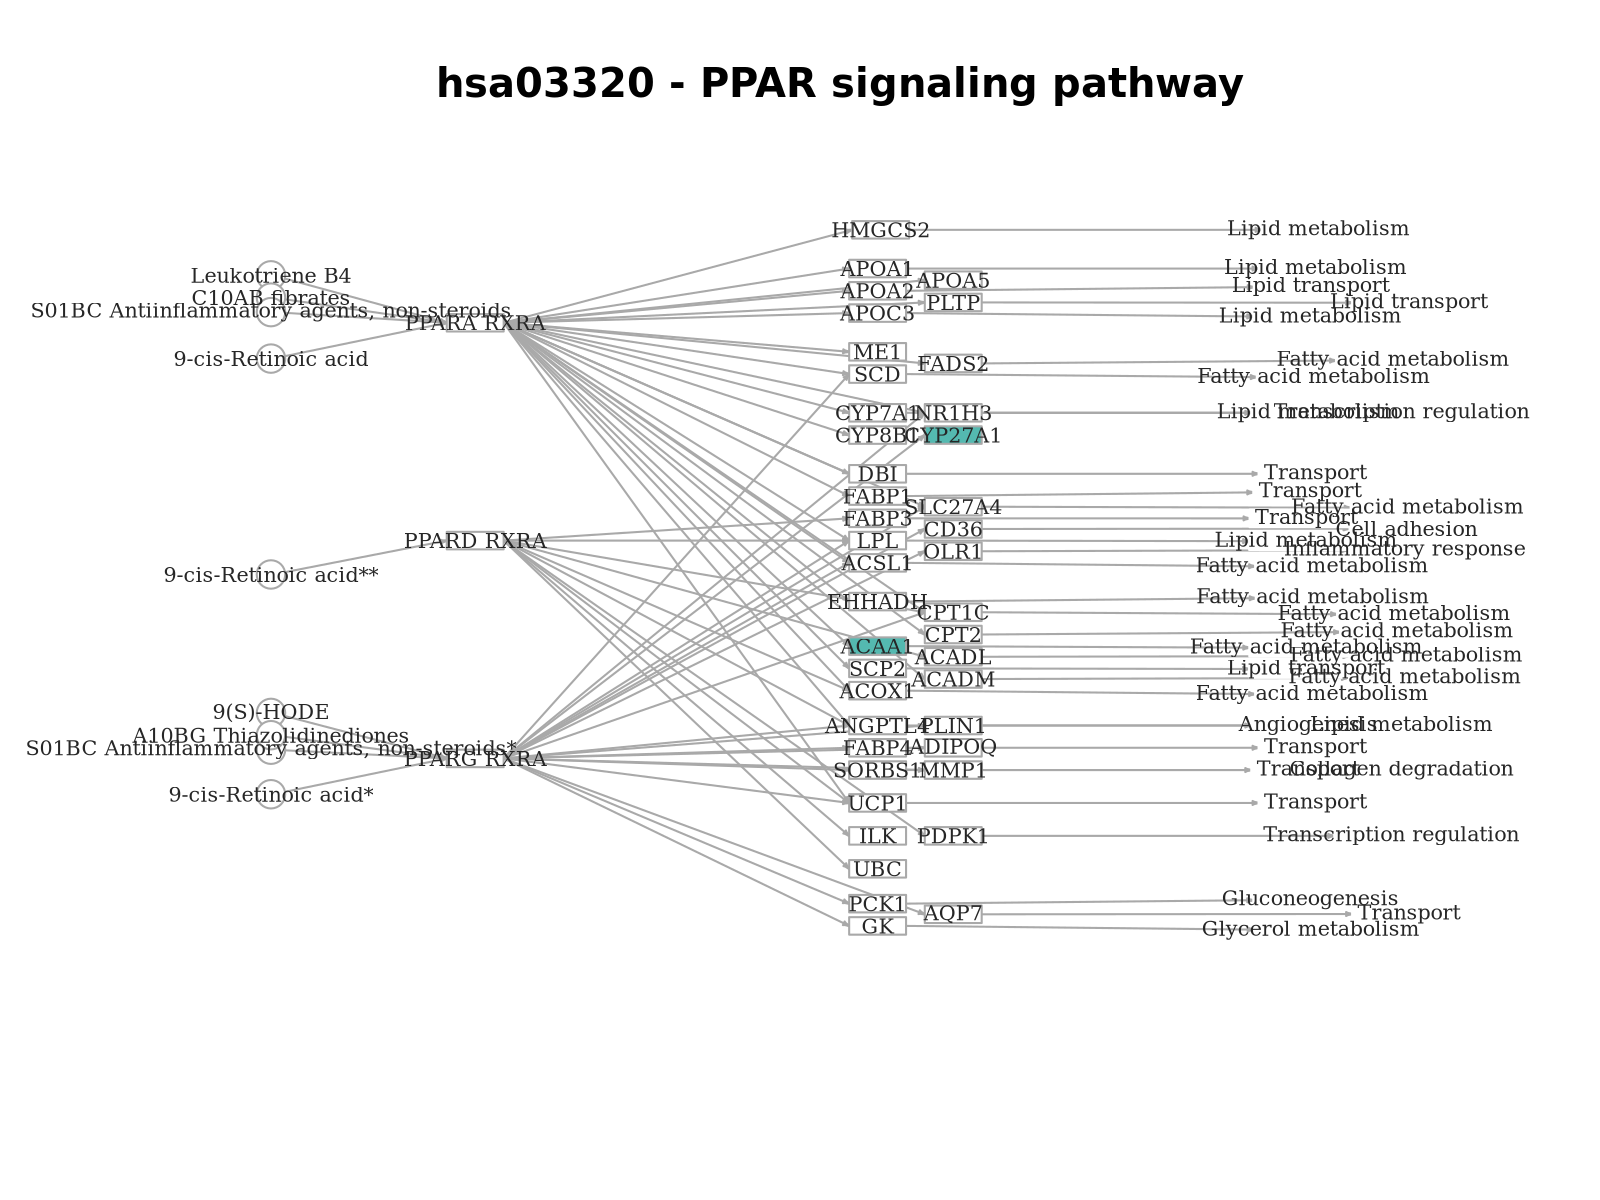

Plotting patient: p4



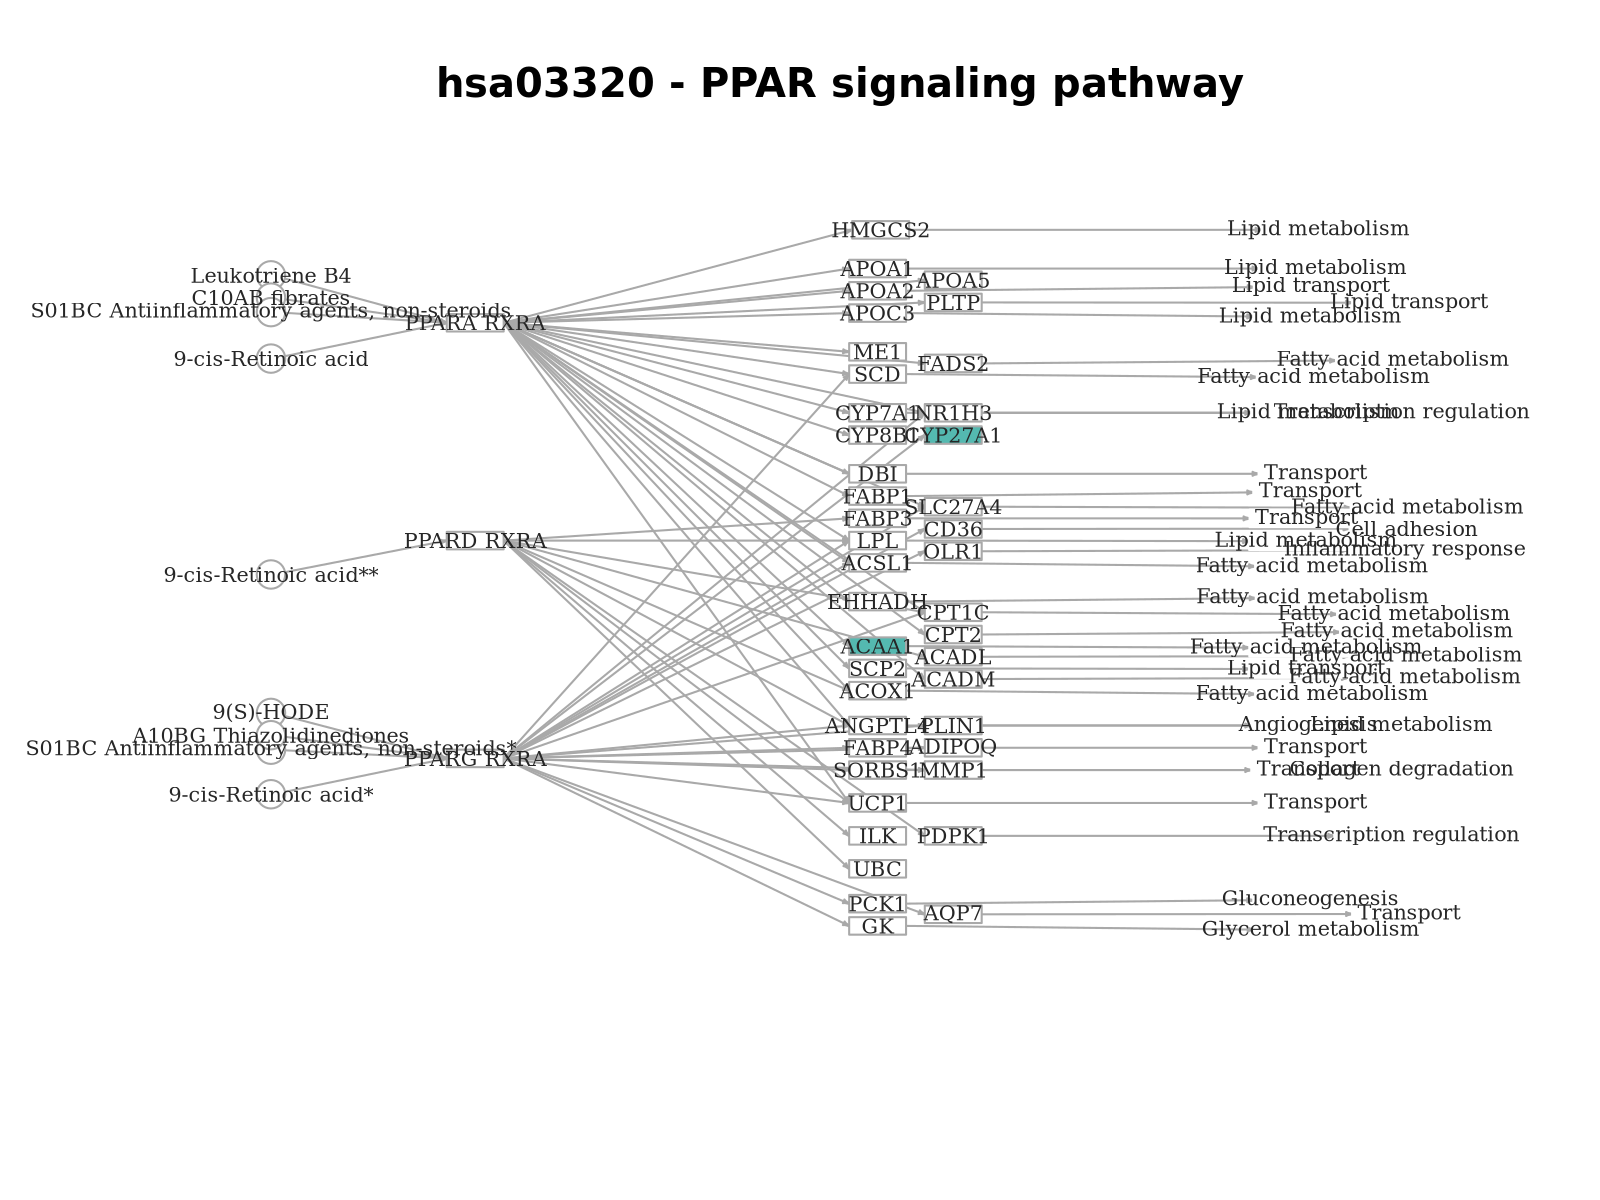

Plotting patient: p13



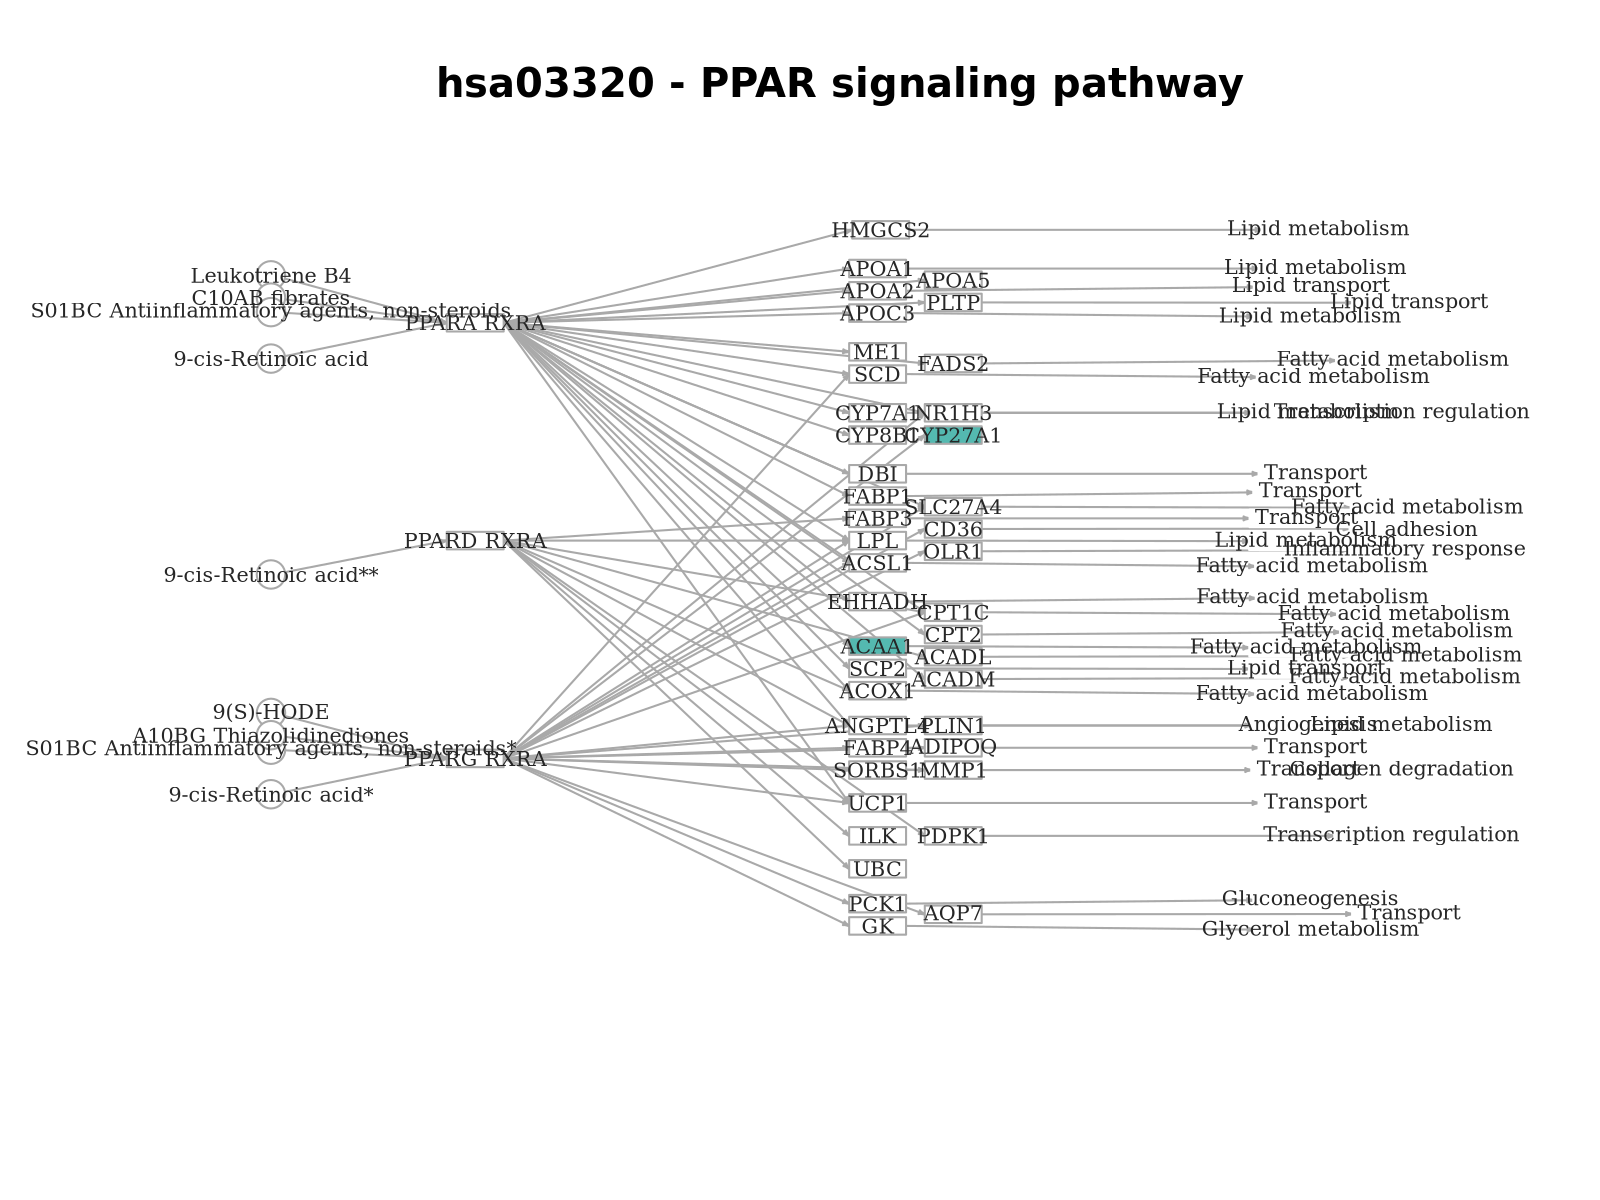

===== 7.5 DISPLAY DONE =====




In [25]:
# ============================================================
# 7.5 Patient-specific pathway comparison plots (Jupyter-safe display)
# Notes:
# - Patient-specific UP/DOWN comes from comp_by_patient[[p]]
# - Node colors are computed globally (all samples) because node_color_per_de()
#   requires >2 samples for stable internal modeling in some setups
# ============================================================

message("\n===== 7.5 SHOWING PATIENT-SPECIFIC COMPARISON PLOTS (JUPYTER) =====")

if (!requireNamespace("IRdisplay", quietly = TRUE)) {
  install.packages("IRdisplay")
}
library(IRdisplay)

stopifnot(exists("comp_by_patient"))
stopifnot(exists("paired_patients"))
stopifnot(exists("results"))
stopifnot(exists("pathways"))
stopifnot(exists("pm"))

# Sample group labels must match the columns of pm (patient_group samples)
sample_group <- sub("^.*_", "", colnames(pm))
names(sample_group) <- colnames(pm)
stopifnot(all(names(sample_group) == colnames(pm)))

# Choose the pathway you want to visualize
pathway_id <- "hsa03320"  # change this to any KEGG pathway ID
message("Visualizing pathway: ", pathway_id)

# Compute node colors globally (robust)
node_colors <- node_color_per_de(
  results,
  pathways,
  sample_group,
  group2_name,   # Tumor
  group1_name,   # Normal
  colors = "hipathia"
)

# Render each patient plot to a temporary file, display it, then delete it
for (p in paired_patients) {
  message("Plotting patient: ", p)

  tmp_png <- tempfile(fileext = ".png")
  png(tmp_png, width = 1600, height = 1200, res = 200)

  pathway_comparison_plot(
    comp_by_patient[[p]],   # patient-specific UP/DOWN
    metaginfo = pathways,
    pathway = pathway_id,
    node_colors = node_colors,  # global node colors for comparability
    colors = "hipathia"
  )

  dev.off()

  IRdisplay::display_png(file = tmp_png)
  unlink(tmp_png)
}

message("===== 7.5 DISPLAY DONE =====\n")


In [26]:
# Compare UP/DOWN calls between patients
tab_p786_p4 <- table(comp_by_patient[["p786"]]$`UP/DOWN`, comp_by_patient[["p4"]]$`UP/DOWN`)
tab_p786_p13 <- table(comp_by_patient[["p786"]]$`UP/DOWN`, comp_by_patient[["p13"]]$`UP/DOWN`)
tab_p4_p13 <- table(comp_by_patient[["p4"]]$`UP/DOWN`, comp_by_patient[["p13"]]$`UP/DOWN`)

print(tab_p786_p4)
print(tab_p786_p13)
print(tab_p4_p13)


      
       DOWN   UP
  DOWN   28   39
  UP     29 1780
      
       DOWN   UP
  DOWN   32   35
  UP     53 1756
      
       DOWN   UP
  DOWN   46   11
  UP     39 1780


In [28]:
# ============================================================
# 8.1 Improved consensus table (with neutral threshold + support)
# ============================================================

message("\n===== 8.1 BUILDING IMPROVED CONSENSUS TABLE =====")

stopifnot(exists("delta_mat"))
stopifnot(is.matrix(delta_mat))

eps <- 0.01  # neutrality threshold; adjust if needed

# Classify per-patient direction with neutrality threshold
dir_mat <- delta_mat
dir_mat[] <- ifelse(delta_mat > eps, 1,
             ifelse(delta_mat < -eps, -1, 0))

n_up  <- rowSums(dir_mat ==  1, na.rm = TRUE)
n_dn  <- rowSums(dir_mat == -1, na.rm = TRUE)
n_neu <- rowSums(dir_mat ==  0, na.rm = TRUE)
n_tot <- ncol(delta_mat)

# Combined effect (median of raw deltas, not the sign matrix)
combined_effect <- matrixStats::rowMedians(delta_mat, na.rm = TRUE)
abs_effect <- abs(combined_effect)

# Support label (how many patients agree in the same direction)
support_n <- pmax(n_up, n_dn)
support <- paste0(support_n, "/", n_tot)

# Consensus call
consensus_call <- ifelse(n_up == n_tot, "UP_all",
                  ifelse(n_dn == n_tot, "DOWN_all",
                  ifelse(n_up >= 2, "UP_majority",
                  ifelse(n_dn >= 2, "DOWN_majority", "mixed"))))

# Compact consensus table
consensus_compact <- data.frame(
  subpathway = rownames(delta_mat),
  combined_effect = combined_effect,
  abs_effect = abs_effect,
  support = support,
  n_up = n_up,
  n_dn = n_dn,
  n_neutral = n_neu,
  consensus = consensus_call,
  stringsAsFactors = FALSE
)

# Keep only majority/all
consensus_compact <- consensus_compact[
  consensus_compact$consensus %in% c("UP_all","DOWN_all","UP_majority","DOWN_majority"),
]

consensus_compact <- consensus_compact[order(consensus_compact$abs_effect, decreasing = TRUE), ]

message("Consensus subpathways (>=2/3, neutrality-aware): ", nrow(consensus_compact))
print(head(consensus_compact, 30))

message("===== 8.1 IMPROVED TABLE DONE =====\n")



===== 8.1 BUILDING IMPROVED CONSENSUS TABLE =====

Consensus subpathways (>=2/3, neutrality-aware): 64



                       subpathway combined_effect abs_effect support n_up n_dn
P-hsa04610-44       P-hsa04610-44      -0.8017846  0.8017846     3/3    0    3
P-hsa04670-86       P-hsa04670-86      -0.7199054  0.7199054     3/3    0    3
P-hsa05014-49       P-hsa05014-49      -0.5819248  0.5819248     2/3    0    2
P-hsa04520-44 47 P-hsa04520-44 47      -0.5718095  0.5718095     3/3    0    3
P-hsa05205-422     P-hsa05205-422      -0.5300836  0.5300836     2/3    0    2
P-hsa05133-73       P-hsa05133-73      -0.4949262  0.4949262     3/3    0    3
P-hsa05205-352     P-hsa05205-352      -0.4940984  0.4940984     2/3    1    2
P-hsa05132-13       P-hsa05132-13      -0.4869112  0.4869112     3/3    0    3
P-hsa04310-22       P-hsa04310-22      -0.4722034  0.4722034     2/3    0    2
P-hsa04152-38       P-hsa04152-38      -0.4668175  0.4668175     3/3    0    3
P-hsa05020-24       P-hsa05020-24      -0.4575301  0.4575301     3/3    0    3
P-hsa05020-26       P-hsa05020-26      -0.4575301  0

===== 8.1 IMPROVED TABLE DONE =====





===== 8.2 CONSENSUS PATHWAY COMPARISON PLOT =====

Visualizing pathway: hsa03320

===== 8.2 CONSENSUS PLOT DONE =====




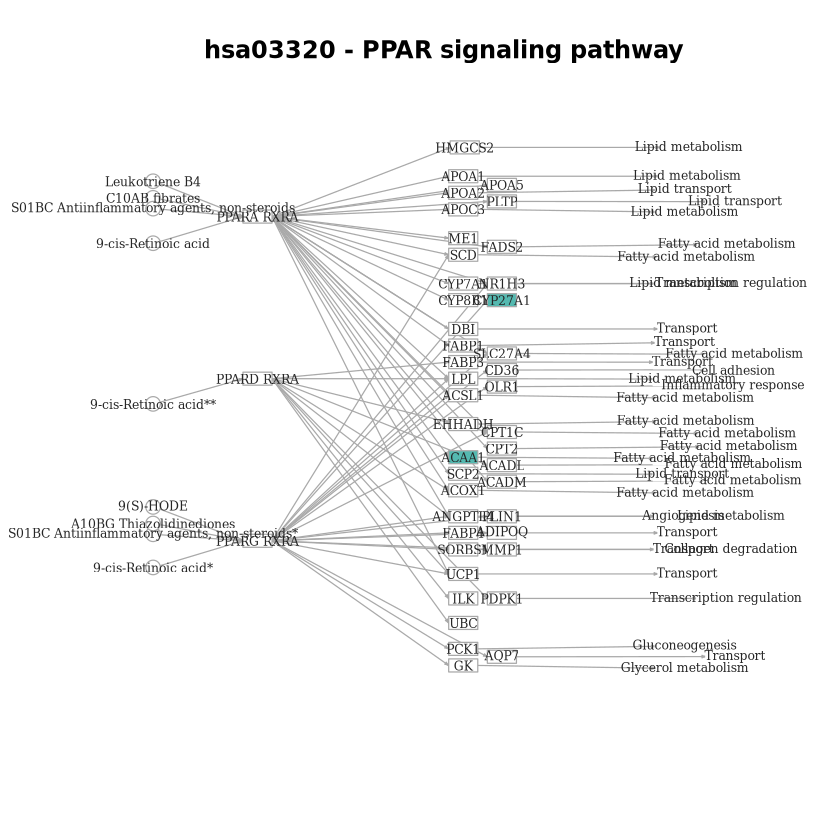

In [29]:
# ============================================================
# 8.2 Consensus comparison plot (combined effect)
# ============================================================

message("\n===== 8.2 CONSENSUS PATHWAY COMPARISON PLOT =====")

stopifnot(exists("combined_effect"))
stopifnot(exists("pm"))
stopifnot(exists("results"))
stopifnot(exists("pathways"))

# Build a Hipathia-compatible comp object from the combined effect
eff_comb <- combined_effect
names(eff_comb) <- rownames(delta_mat)

comp_consensus <- data.frame(
  p.value = rep(1, length(eff_comb)),
  FDRp.value = rep(1, length(eff_comb)),
  stringsAsFactors = FALSE,
  row.names = names(eff_comb)
)
comp_consensus$`UP/DOWN` <- ifelse(eff_comb >= 0, "UP", "DOWN")

# Sample group labels must match pm columns (patient_group samples)
sample_group <- sub("^.*_", "", colnames(pm))
names(sample_group) <- colnames(pm)

# Choose pathway
pathway_id <- "hsa03320"  # change if needed
message("Visualizing pathway: ", pathway_id)

node_colors <- node_color_per_de(
  results,
  pathways,
  sample_group,
  group2_name,   # Tumor
  group1_name,   # Normal
  colors = "hipathia"
)

pathway_comparison_plot(
  comp_consensus,
  metaginfo = pathways,
  pathway = pathway_id,
  node_colors = node_colors,
  colors = "hipathia"
)

message("===== 8.2 CONSENSUS PLOT DONE =====\n")



===== 8.3 MINI CHECK: EFFECT DISTRIBUTION & DIRECTION BIAS =====



dir_calls
   DOWN NEUTRAL      UP 
     60    1812       4 
       1%        5%       25%       50%       75%       95%       99% 
-0.368811  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000 


Mean combined_effect: -0.00892810278665064

Median combined_effect: 0

Per-patient mean delta:



        p786           p4          p13 
-0.009540311 -0.008171431 -0.015861263 


Per-patient median delta:



p786   p4  p13 
   0    0    0 


===== 8.3 MINI CHECK DONE =====




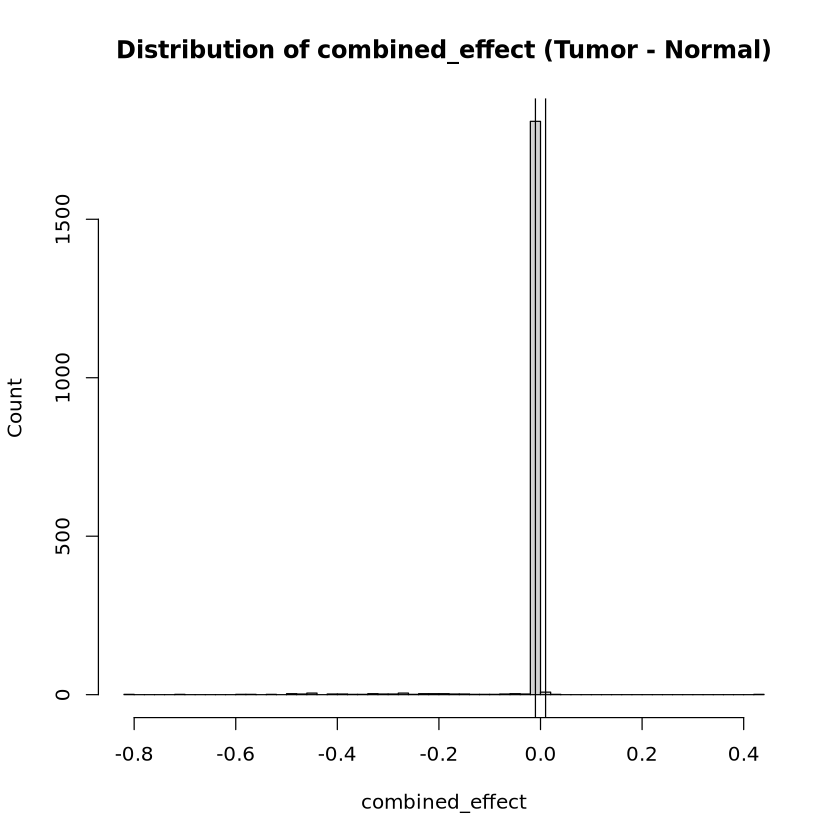

In [30]:
# ============================================================
# 8.3 Mini check: direction bias and effect distribution
# ============================================================

message("\n===== 8.3 MINI CHECK: EFFECT DISTRIBUTION & DIRECTION BIAS =====")

stopifnot(exists("delta_mat"))
stopifnot(is.matrix(delta_mat))
stopifnot(exists("combined_effect"))

eps <- 0.01  # keep consistent with your consensus threshold

# Direction counts (neutrality-aware)
dir_calls <- ifelse(combined_effect > eps, "UP",
             ifelse(combined_effect < -eps, "DOWN", "NEUTRAL"))

tab_dir <- table(dir_calls)
print(tab_dir)

# Summary statistics
qs <- quantile(combined_effect, probs = c(0.01,0.05,0.25,0.5,0.75,0.95,0.99), na.rm = TRUE)
print(qs)

message("Mean combined_effect: ", mean(combined_effect, na.rm = TRUE))
message("Median combined_effect: ", median(combined_effect, na.rm = TRUE))

# Plot histogram
hist(
  combined_effect,
  breaks = 50,
  main = "Distribution of combined_effect (Tumor - Normal)",
  xlab = "combined_effect",
  ylab = "Count"
)
abline(v = c(-eps, eps))

# Per-patient sanity check: are deltas centered similarly?
patient_means <- colMeans(delta_mat, na.rm = TRUE)
patient_medians <- apply(delta_mat, 2, median, na.rm = TRUE)

message("Per-patient mean delta:")
print(patient_means)

message("Per-patient median delta:")
print(patient_medians)

message("===== 8.3 MINI CHECK DONE =====\n")



===== 8.4 AUTO-SELECTING PATHWAY FOR CONSENSUS PLOT =====



    pathway count   sum_abs
7  hsa04530     5 1.0528981
14 hsa05020     4 1.8301203
26 hsa05205     4 1.6034295
17 hsa05132     3 1.0758947
25 hsa05200     3 0.9445848
23 hsa05168     3 0.9183392
16 hsa05031     3 0.7327802
20 hsa05160     3 0.6919700
6  hsa04520     2 0.8818560
24 hsa05169     2 0.7514722


Auto-selected pathway: hsa04530

===== 8.4 AUTO CONSENSUS PLOT DONE =====




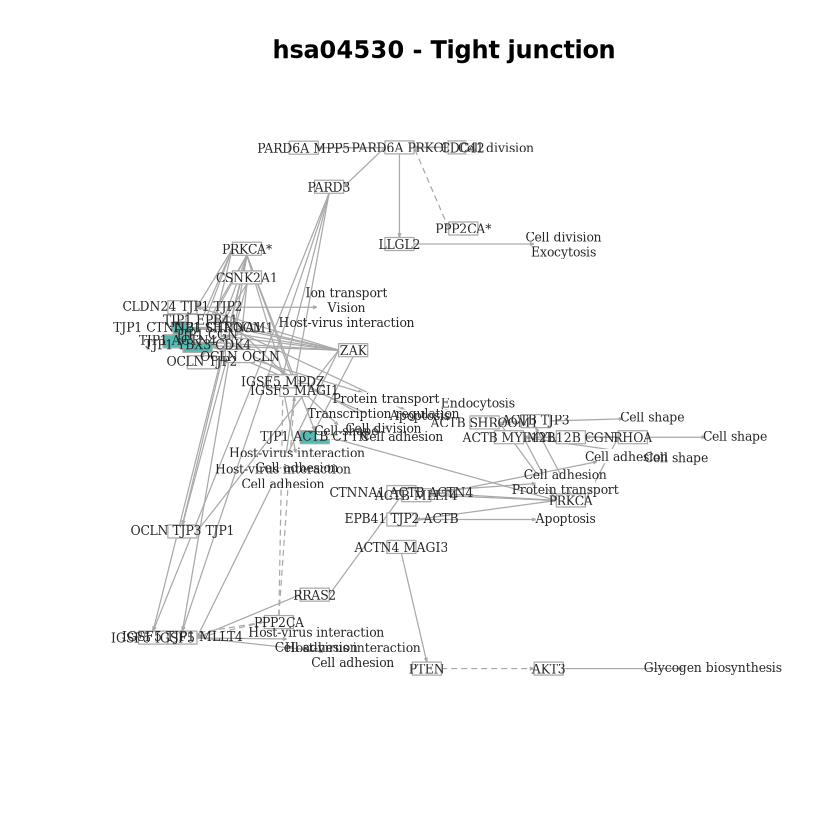

In [31]:
# ============================================================
# 8.4 Auto-select pathway from top consensus subpathways + plot
# ============================================================

message("\n===== 8.4 AUTO-SELECTING PATHWAY FOR CONSENSUS PLOT =====")

stopifnot(exists("consensus_compact"))
stopifnot(exists("combined_effect"))
stopifnot(exists("delta_mat"))
stopifnot(exists("pm"))
stopifnot(exists("results"))
stopifnot(exists("pathways"))

top_k <- 50  # adjust (e.g., 30/50/100)
top_ids <- head(consensus_compact$subpathway, min(top_k, nrow(consensus_compact)))

# Extract KEGG pathway id from subpathway id: "P-hsa04610-44" -> "hsa04610"
top_path <- vapply(strsplit(top_ids, "-"), function(x) if (length(x) >= 2) x[2] else NA_character_, character(1))
top_eff  <- abs(combined_effect[top_ids])

sel_df <- data.frame(
  subpathway = top_ids,
  pathway = top_path,
  abs_effect = top_eff,
  stringsAsFactors = FALSE
)
sel_df <- sel_df[!is.na(sel_df$pathway), , drop = FALSE]

# Rank pathways by: (1) number of top subpathways, (2) sum abs_effect
path_summary <- aggregate(
  abs_effect ~ pathway,
  data = sel_df,
  FUN = function(x) c(count = length(x), sum_abs = sum(x, na.rm = TRUE))
)

# Unpack the matrix column
path_summary$count <- path_summary$abs_effect[, "count"]
path_summary$sum_abs <- path_summary$abs_effect[, "sum_abs"]
path_summary$abs_effect <- NULL

path_summary <- path_summary[order(path_summary$count, path_summary$sum_abs, decreasing = TRUE), ]
print(head(path_summary, 10))

pathway_id <- path_summary$pathway[1]
message("Auto-selected pathway: ", pathway_id)

# Build a Hipathia-compatible comp object from the combined effect (consensus)
eff_comb <- combined_effect
names(eff_comb) <- rownames(delta_mat)

comp_consensus <- data.frame(
  p.value = rep(1, length(eff_comb)),
  FDRp.value = rep(1, length(eff_comb)),
  stringsAsFactors = FALSE,
  row.names = names(eff_comb)
)
comp_consensus$`UP/DOWN` <- ifelse(eff_comb >= 0, "UP", "DOWN")

# Sample group labels must match pm columns (patient_group samples)
sample_group <- sub("^.*_", "", colnames(pm))
names(sample_group) <- colnames(pm)
stopifnot(all(names(sample_group) == colnames(pm)))

node_colors <- node_color_per_de(
  results,
  pathways,
  sample_group,
  group2_name,   # Tumor
  group1_name,   # Normal
  colors = "hipathia"
)

pathway_comparison_plot(
  comp_consensus,
  metaginfo = pathways,
  pathway = pathway_id,
  node_colors = node_colors,
  colors = "hipathia"
)

message("===== 8.4 AUTO CONSENSUS PLOT DONE =====\n")



===== 8.4 AUTO-SELECTING PATHWAY + PLOTTING CONSENSUS =====



    pathway   sum_abs
14 hsa05020 1.8301203
26 hsa05205 1.6034295
17 hsa05132 1.0758947
7  hsa04530 1.0528981
25 hsa05200 0.9445848
23 hsa05168 0.9183392
6  hsa04520 0.8818560
8  hsa04610 0.8017846
24 hsa05169 0.7514722
2  hsa04152 0.7483747


Auto-selected pathway (sum_abs): hsa05020

===== 8.4 DONE =====




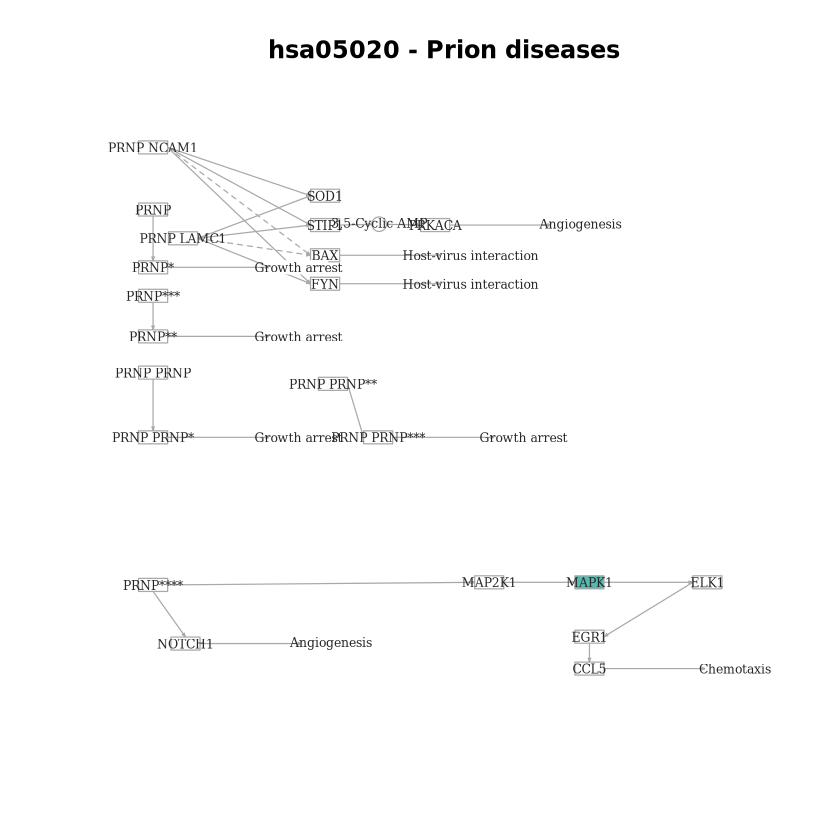

In [36]:
# ============================================================
# 8.4 Auto-select pathway (sum_abs) + consensus comparison plot
# ============================================================

message("\n===== 8.4 AUTO-SELECTING PATHWAY + PLOTTING CONSENSUS =====")

stopifnot(exists("consensus_compact"))
stopifnot(exists("combined_effect"))
stopifnot(exists("delta_mat"))
stopifnot(exists("pm"))
stopifnot(exists("results"))
stopifnot(exists("pathways"))

# --- 1) Auto-select pathway by sum of absolute effects ---
top_k <- 50
top_ids <- head(consensus_compact$subpathway, min(top_k, nrow(consensus_compact)))

top_path <- vapply(
  strsplit(top_ids, "-"),
  function(x) if (length(x) >= 2) x[2] else NA_character_,
  character(1)
)
top_eff <- abs(combined_effect[top_ids])

sel_df <- data.frame(
  subpathway = top_ids,
  pathway = top_path,
  abs_effect = top_eff,
  stringsAsFactors = FALSE
)
sel_df <- sel_df[!is.na(sel_df$pathway), , drop = FALSE]

path_summary <- aggregate(abs_effect ~ pathway, data = sel_df, FUN = sum, na.rm = TRUE)
colnames(path_summary)[2] <- "sum_abs"
path_summary <- path_summary[order(path_summary$sum_abs, decreasing = TRUE), ]

print(head(path_summary, 10))

pathway_id <- path_summary$pathway[1]
message("Auto-selected pathway (sum_abs): ", pathway_id)

# --- 2) Build Hipathia-compatible comp object from combined effect ---
eff_comb <- combined_effect
names(eff_comb) <- rownames(delta_mat)

comp_consensus <- data.frame(
  p.value = rep(1, length(eff_comb)),
  FDRp.value = rep(1, length(eff_comb)),
  stringsAsFactors = FALSE,
  row.names = names(eff_comb)
)
comp_consensus$`UP/DOWN` <- ifelse(eff_comb >= 0, "UP", "DOWN")

# --- 3) Global sample group labels (6 samples) ---
sample_group <- sub("^.*_", "", colnames(pm))
names(sample_group) <- colnames(pm)
stopifnot(all(names(sample_group) == colnames(pm)))

# --- 4) Global node colors (robust) ---
node_colors <- node_color_per_de(
  results,
  pathways,
  sample_group,
  group2_name,   # Tumor
  group1_name,   # Normal
  colors = "hipathia"
)

# --- 5) Plot ---
pathway_comparison_plot(
  comp_consensus,
  metaginfo = pathways,
  pathway = pathway_id,
  node_colors = node_colors,
  colors = "hipathia"
)

message("===== 8.4 DONE =====\n")


# X

In [32]:
message("\n===== AGGREGATING PATHWAY ACTIVITY PER PATIENT × GROUP =====")

library(matrixStats)

# pm: subpathways x cells
# design_cell: metadata aligned to pm columns
stopifnot(all(colnames(pm) == design_cell$cell_id))

# Build patient-group labels per cell
pg_label <- paste0(design_cell$patient_id, "_", design_cell$group)
pg_levels <- unique(pg_label)

# Compute median pathway activity per patient × group
pm_pg_median <- sapply(
  pg_levels,
  function(g) {
    rowMedians(pm[, pg_label == g, drop = FALSE])
  }
)

colnames(pm_pg_median) <- pg_levels

message(
  "Aggregated matrix dimensions: ",
  nrow(pm_pg_median), " subpathways × ",
  ncol(pm_pg_median), " patient-group samples"
)

# Identify paired patients (must have both groups)
patients <- intersect(
  unique(design_cell$patient_id[design_cell$group == group1_name]),
  unique(design_cell$patient_id[design_cell$group == group2_name])
)

if (length(patients) == 0) {
  stop("No paired patients found after filtering.")
}

message("Paired patients: ", paste(patients, collapse = ", "))

# Compute paired delta per patient (Tumor - Normal)
delta_mat <- sapply(
  patients,
  function(p) {
    pm_pg_median[, paste0(p, "_", group2_name)] -
      pm_pg_median[, paste0(p, "_", group1_name)]
  }
)

colnames(delta_mat) <- patients

message(
  "Delta matrix dimensions: ",
  nrow(delta_mat), " subpathways × ",
  ncol(delta_mat), " patients"
)

message("===== PATIENT-LEVEL AGGREGATION COMPLETED =====\n")



===== AGGREGATING PATHWAY ACTIVITY PER PATIENT × GROUP =====



ERROR: Error: all(colnames(pm) == design_cell$cell_id) is not TRUE


In [ ]:
apply(delta_mat, 2, function(x) var(x, na.rm = TRUE))


## 9. Preprocessment & Hipathia Normalization

In [ ]:
# ============================================================
# 9. Paired statistical testing across patients
# ============================================================

message("\n===== RUNNING PAIRED STATISTICAL TESTS (PATIENT LEVEL) =====")

# delta_mat: subpathways x patients
stopifnot(is.matrix(delta_mat))
stopifnot(ncol(delta_mat) >= 2)

# Paired test per subpathway
p_values <- apply(
  delta_mat,
  1,
  function(x) {
    x <- x[!is.na(x)]
    
    # No variation -> no information
    if (length(x) < 2 || all(x == 0)) {
      return(NA_real_)
    }
    
    suppressWarnings(
      wilcox.test(x, mu = 0)$p.value
    )
  }
)

# Build results table
comp_subpathway <- data.frame(
  subpathway = rownames(delta_mat),
  p_value    = p_values,
  stringsAsFactors = FALSE
)

# FDR correction
comp_subpathway$FDR <- p.adjust(comp_subpathway$p_value, method = "BH")

# Basic summary
message("Total subpathways tested: ", nrow(comp_subpathway))
message("Valid p-values: ", sum(!is.na(comp_subpathway$p_value)))
message("Min raw p-value: ", min(comp_subpathway$p_value, na.rm = TRUE))
message("Min FDR: ", min(comp_subpathway$FDR, na.rm = TRUE))

message("===== STATISTICAL TESTING DONE =====\n")

# Inspect top hits
head(comp_subpathway[order(comp_subpathway$p_value), ], 10)


### 10.1. Download Pathaways

In [ ]:
## ===========================
## 4.1 Load Hipathia Pathways
## ===========================

if (length(pathways_list) == 0) {
    message("Loading ALL pathways for species: ", species)
    pathways <- load_pathways(species = species)
} else {
    message("Loading selected pathways: ", paste(pathways_list, collapse = ", "))
    pathways <- load_pathways(species = species, pathways_list = pathways_list)
}

# --- Basic diagnostics ---
message("Number of pathways loaded: ", length(pathways))

# Show first 5 pathway names (if available)
if (length(pathways) >= 5) {
    print(names(pathways)[1:5])
} else {
    print(names(pathways))
}

# Show first 10 identifiers from Hipathia list
pw_list <- get_pathways_list(pathways)
print(head(pw_list, 10))


### 10. 2. Compute the signal

In [ ]:
#4.3 Using Hipathia to comute the signal
results <- hipathia(exp_data, pathways, decompose = FALSE, verbose=FALSE)
## Added missing genes: 165 (4.93%)

In [ ]:
# Gene IDs in deiner Expression Matrix
input_genes <- rownames(exp_data)

# Alle Gene, die Hipathia benötigt
hipathia_genes <- unique(unlist(lapply(pathways$pathigraphs, function(p) p$genes)))

# Gene, die Hipathia braucht, aber du nicht hast
missing_genes <- setdiff(hipathia_genes, input_genes)

length(missing_genes)
head(missing_genes, 50)
# So niedriger des do besser
                                    

In [ ]:
#4.3 Using Hipathia to comute the signal
results

In [ ]:
#4.3 Using Hipathia to comute the signal
path_vals <- get_paths_data(results)
hhead(path_vals, 4)

## 10. Aggregate subpathways to pathway-level

In [ ]:
# Restore subpathway rownames for delta_mat
rownames(delta_mat) <- rownames(pm)

# Sanity check
stopifnot(!is.null(rownames(delta_mat)))


In [ ]:
# ============================================================
# 10.1 Aggregate subpathways to pathway-level (keep both)
# ============================================================

message("\n===== AGGREGATING SUBPATHWAYS TO PATHWAY LEVEL =====")

# delta_mat: subpathways x patients
stopifnot(is.matrix(delta_mat))
stopifnot(!is.null(rownames(delta_mat)))

# Extract KEGG pathway id from subpathway id
# Expected format: "P-hsa04150-23" -> "hsa04150"
sub_to_path <- vapply(
  strsplit(rownames(delta_mat), "-"),
  function(x) {
    if (length(x) >= 2) x[2] else NA_character_
  },
  FUN.VALUE = character(1)
)

# Drop rows where pathway id could not be parsed
keep_idx <- !is.na(sub_to_path)
delta_mat2 <- delta_mat[keep_idx, , drop = FALSE]
sub_to_path2 <- sub_to_path[keep_idx]

# Aggregate using median across subpathways within each pathway
delta_pathway <- rowsum(delta_mat2, group = sub_to_path2, reorder = FALSE) /
  as.numeric(table(sub_to_path2))

# Note: rowsum gives mean-like behavior here; for strict median aggregation,
# we'd need split-apply. Mean is fine for pathway summary; subpathways remain available.

message("Pathway-level delta dimensions: ", nrow(delta_pathway), " x ", ncol(delta_pathway))

# Pathway-level statistical test across patients (same logic as Step 9)
p_path <- apply(
  delta_pathway,
  1,
  function(x) {
    x <- x[!is.na(x)]
    if (length(x) < 2 || all(x == 0)) return(NA_real_)
    suppressWarnings(wilcox.test(x, mu = 0)$p.value)
  }
)

comp_pathway <- data.frame(
  pathway = rownames(delta_pathway),
  p_value = p_path,
  stringsAsFactors = FALSE
)
comp_pathway$FDR <- p.adjust(comp_pathway$p_value, method = "BH")

message("Total pathways tested: ", nrow(comp_pathway))
message("Valid p-values: ", sum(!is.na(comp_pathway$p_value)))
message("Min raw p-value: ", min(comp_pathway$p_value, na.rm = TRUE))
message("Min FDR: ", min(comp_pathway$FDR, na.rm = TRUE))

message("===== PATHWAY-LEVEL AGGREGATION DONE =====\n")

# Inspect top pathways
head(comp_pathway[order(comp_pathway$p_value), ], 10)


## X

In [ ]:
# ============================================================
# 11. Prepare Hipathia-compatible comp object (subpathway-level)
# ============================================================

message("\n===== PREPARING HIPATHIA-COMPATIBLE COMP OBJECT =====")

# Ensure rownames exist (subpathway IDs)
stopifnot(!is.null(rownames(delta_mat)))

# ============================================================
# 11. Prepare Hipathia-compatible comp object (subpathway-level)
# ============================================================

message("\n===== PREPARING HIPATHIA-COMPATIBLE COMP OBJECT =====")

stopifnot(exists("comp_subpathway"))
stopifnot(exists("delta_mat"))
stopifnot(!is.null(rownames(delta_mat)))

comp_plot <- comp_subpathway
rownames(comp_plot) <- comp_plot$subpathway

# Hipathia naming conventions
comp_plot$p.value <- comp_plot$p_value
comp_plot$FDRp.value <- comp_plot$FDR

# Direction column name must be exactly "UP/DOWN"
mean_delta_sub <- rowMeans(delta_mat, na.rm = TRUE)
comp_plot$`UP/DOWN` <- ifelse(mean_delta_sub[rownames(comp_plot)] >= 0, "UP", "DOWN")

# Critical: replace NA FDR with 1 (non-significant) to avoid if(NA) crashes in plotting
comp_plot$FDRp.value[is.na(comp_plot$FDRp.value)] <- 1
comp_plot$p.value[is.na(comp_plot$p.value)] <- 1

message("comp_plot rows: ", nrow(comp_plot))
message("===== COMP OBJECT READY =====\n")


In [ ]:
# ============================================================
# 11. Pathway comparison plot (Tumor vs Normal)
# ============================================================

message("\n===== CREATING PATHWAY COMPARISON PLOT =====")

library(hipathia)

# Select a pathway to visualize (example)
# Replace with any KEGG pathway ID you want
# ============================================================
# 12. Pathway comparison plot (Tumor vs Normal)
# ============================================================

message("\n===== CREATING PATHWAY COMPARISON PLOT =====")

pathway_id <- "hsa03320"  # change this to any pathway you want
message("Visualizing pathway: ", pathway_id)

# Cell-level group labels
sample_group <- design_cell$group
names(sample_group) <- design_cell$cell_id

node_colors <- node_color_per_de(
  results,
  pathways,
  sample_group,
  group2_name,   # Tumor
  group1_name,   # Normal
  colors = "hipathia"
)

pathway_comparison_plot(
  comp_plot,
  metaginfo = pathways,
  pathway = pathway_id,
  node_colors = node_colors,
  colors = "hipathia"
)

message("===== PATHWAY COMPARISON PLOT DONE =====")


## 11. Functional Annotation: UniProt & GO Term Activation

In [ ]:
#5 Function activation computation
uniprot_vals <- quantify_terms(results, pathways, dbannot = "uniprot")

go_vals <- quantify_terms(results, pathways, dbannot = "GO")
#142/1654 soll so sein

## 12. Pathway/Function activation analysis

### 11.1 Sample design extraction from pathway matrix

In [ ]:
sample_ids <- colnames(path_vals)

design <- data.frame(
    sample  = sample_ids,
    patient = sub("_(.*)$", "", sample_ids),
    group   = sub("^.*_", "", sample_ids),
    row.names = sample_ids,
    stringsAsFactors = FALSE
)

sample_group <- design$group
names(sample_group) <- design$sample


### 11.2 Extract numeric matrix from path_vals (Hipathia-compatible)

In [ ]:
if (inherits(path_vals, "SummarizedExperiment")) {
    pm <- assay(path_vals)

} else if (is.list(path_vals) && !is.null(path_vals[[1]]) &&
           (is.matrix(path_vals[[1]]) || inherits(path_vals[[1]], "DelayedMatrix"))) {
    pm <- as.matrix(path_vals[[1]])

} else if (is.matrix(path_vals)) {
    pm <- path_vals

} else {
    stop("ERROR: path_vals hat einen unbekannten Datentyp und kann nicht in eine Matrix umgewandelt werden.")
}

# Sicherheitscheck
if (!is.matrix(pm)) stop("pm ist keine Matrix.")

### 11.3. Extract pathway IDs from subpathway IDs

In [ ]:
sub_to_path <- vapply(
    strsplit(rownames(pm), "-"),
    function(x) x[2],
    FUN.VALUE = character(1)
)

### 11.4.  Aggregate subpathway activations → pathway-level matrix

In [ ]:
message("Aggregiere Subpathways zu Pathways...")

pathlevel_vals <- rowsum(pm, group = sub_to_path)


### 11.4. Paired Wilcoxon test per pathway

In [ ]:
zero_diff <- character(0)
unpaired  <- character(0)

pvals <- suppressWarnings(sapply(rownames(pathlevel_vals), function(p) {

    vals <- pathlevel_vals[p, ]

    g1 <- vals[design$group == group1_name]
    g2 <- vals[design$group == group2_name]

    # gleiche Anzahl Samples für Pairing?
    if (length(g1) != length(g2)) {
        unpaired <<- c(unpaired, p)
        return(NA_real_)
    }

    # keine Unterschiede?
    if (all(g1 - g2 == 0)) {
        zero_diff <<- c(zero_diff, p)
        return(NA_real_)
    }

    # paired Wilcoxon
    tryCatch(
        wilcox.test(g1, g2, paired = TRUE)$p.value,
        error = function(e) NA_real_
    )
}))

### 11.5. Summary and Results

In [ ]:

comp <- data.frame(
    pathway = rownames(pathlevel_vals),
    p_value = pvals,
    stringsAsFactors = FALSE
)

cat("\n===== Wilcoxon paired summary =====\n")
cat("Vergleich:", group1_name, "vs", group2_name, "\n")
cat("Total pathways:", nrow(comp), "\n")
cat("Out-of-pair:", length(unpaired), "\n")
cat("Zero-diff:", length(zero_diff), "\n")

if (length(zero_diff) > 0) {
    cat("Beispiele Zero-diff:\n")
    print(head(zero_diff, 5))
}

if (length(unpaired) > 0) {
    cat("Beispiele unpaired:\n")
    print(head(unpaired, 5))
}

# Ausgabe
head(comp)


## 13. Significant Test

### 12.1. RAW Significance Check (before FDR)

In [ ]:
alpha_strict <- 0.05
alpha_loose  <- 0.10

# Nur Zeilen mit gültigen p-Werten berücksichtigen
valid_idx <- !is.na(comp$p_value)

comp$significant_raw_strict <- FALSE
comp$significant_raw_loose  <- FALSE

comp$significant_raw_strict[valid_idx] <- comp$p_value[valid_idx] < alpha_strict
comp$significant_raw_loose[valid_idx]  <- comp$p_value[valid_idx] < alpha_loose

sig_strict <- comp$pathway[comp$significant_raw_strict]
sig_loose  <- comp$pathway[comp$significant_raw_loose]

cat("\n===== RAW SIGNIFICANCE (before FDR) =====\n")
cat("Strict significant (p < 0.05): ", length(sig_strict), "\n")
if (length(sig_strict) > 0) print(sig_strict)

cat("\nLoose significant (p < 0.10): ", length(sig_loose), "\n")
if (length(sig_loose) > 0) print(sig_loose)

cat("\nTop pathways by raw p-value:\n")
print(head(comp[order(comp$p_value), ], 10))


### 12.2. FDR Correction (Benjamini–Hochberg)

In [ ]:
valid_idx <- !is.na(comp$p_value)

comp$FDR <- NA_real_
comp$FDR[valid_idx] <- p.adjust(comp$p_value[valid_idx], method = "BH")

cat("\n===== FDR Correction Done =====\n")
cat("Anzahl Pfade mit gültigem p-value:", sum(valid_idx), "\n")
cat("Min raw p-value: ", min(comp$p_value[valid_idx]), "\n")
cat("Min FDR value:  ", min(comp$FDR[valid_idx]), "\n")

# Top 10 nach FDR
cat("\nTop pathways by FDR:\n")
print(head(comp[order(comp$FDR), ], 10))


## 14. Mapping pathway p-values onto subpathways

In [ ]:
# =======================================================
# Mapping der Wilcoxon Pathway-p-values zurück
# auf Hipathia Subpathways
# =======================================================

message("\n===== Mapping pathway p-values zurück auf Subpathways =====")

# 1) Alle Subpathway-Namen holen
subpaths <- rownames(path_vals)

# 2) Pathway-ID aus Subpathway extrahieren
#    "P-hsa03320-37" -> "hsa03320"
subpath_path_id <- sapply(strsplit(subpaths, "-"), `[`, 2)

# 3) comp$pathway enthält die hsaXXXX Pathway-Namen aus deinem Wilcoxon
#    -> matchen p-Werte pro Subpath
mapped_pvals <- comp$p_value[ match(subpath_path_id, comp$pathway) ]

# 4) Neues comp im Hipathia-Format erzeugen
comp_expanded <- data.frame(
    pathway = subpath_path_id,
    p_value = mapped_pvals,
    row.names = subpaths,
    stringsAsFactors = FALSE
)

# 5) Ausgabe
message("Subpaths insgesamt: ", length(subpaths))
message("Unique pathways: ", length(unique(subpath_path_id)))
message("Nicht gematcht (NA): ", sum(is.na(mapped_pvals)))

# 6) comp ersetzen
comp <- comp_expanded

head(comp)




In [ ]:
unique(subpath_path_id[is.na(mapped_pvals)])

#"hsa04150" "hsa04912" "hsa04917"

table(subpath_path_id[is.na(mapped_pvals)])


In [ ]:
#6.1  Two classes comparison
pathways_summary <- get_pathways_summary(comp, pathways)
head(pathways_summary, 4)

## 15. Delta PCA

### 15.1. Delta pathway activity (Tumor – Normal) and PCA

In [ ]:
message("\n===== Delta Pathway Activity Calculation =====")

# Pathway-level activation matrix
pm <- assay(path_vals)          # pathways × samples
samples <- colnames(pm)

# Extract patient + group assignment
patients <- design$patient
groups   <- design$group

# Identify paired patients (Normal + Tumor available)
paired_patients <- intersect(
    design$patient[design$group == group1_name],
    design$patient[design$group == group2_name]
)

if (length(paired_patients) == 0) {
    stop("No paired patients found for Delta calculation.")
}

# Prepare Delta matrix
delta_mat <- matrix(
    NA,
    nrow = nrow(pm),
    ncol = length(paired_patients),
    dimnames = list(rownames(pm), paired_patients)
)

# Compute Tumor - Normal per patient (paired)
for (p in paired_patients) {

    # sample IDs
    s_normal <- design$sample[design$patient == p & design$group == group1_name]
    s_tumor  <- design$sample[design$patient == p & design$group == group2_name]

    # compute delta
    delta_mat[, p] <- pm[, s_tumor] - pm[, s_normal]
}

message("Delta matrix: ", nrow(delta_mat), " pathways × ", ncol(delta_mat), " patients")

In [ ]:
apply(delta_mat, 2, function(x) var(x, na.rm = TRUE))[1:10]


### 15.2. Delta Pathway Activity PCA

In [ ]:

message("\n===== Delta Pathway Activity PCA =====")

# --- 0. Remove zero-variance columns ----------------------------------------

zero_var_cols <- which(apply(delta_mat, 2, function(x) var(x, na.rm=TRUE) == 0))

if (length(zero_var_cols) > 0) {
    message("Removing ", length(zero_var_cols),
            " patient(s) with zero variance:")
    print(colnames(delta_mat)[zero_var_cols])
    
    delta_mat_pca <- delta_mat[, -zero_var_cols, drop = FALSE]
} else {
    delta_mat_pca <- delta_mat
}

# Must have at least 2 patients remaining
if (ncol(delta_mat_pca) < 2) {
    stop("Not enough patients with non-zero delta variance for PCA.")
}

# --- 1. Try PCA with scaling ------------------------------------------------

message("Trying PCA with scaling (scale=TRUE)...")

pca_res <- NULL

try({
    pca_res <- prcomp(t(delta_mat_pca), scale. = TRUE)
})

if (!is.null(pca_res)) {
    message("PCA with scale=TRUE succeeded.")
    
} else {

    # --- 2. If scaling PCA fails → use no scaling ---------------------------

    message("PCA with scale=TRUE failed — retrying WITHOUT scaling (scale=FALSE)...")

    try({
        pca_res <- prcomp(t(delta_mat_pca), scale. = FALSE)
    })

    if (!is.null(pca_res)) {
        message("PCA with scale=FALSE succeeded.")
    } else {
        stop("PCA failed: both scaling and no-scaling PCA could not be computed.")
    }
}

# --- 3. Output --------------------------------------------------------------

print(summary(pca_res))

plot(
    pca_res$x[,1], pca_res$x[,2],
    xlab = "PC1", ylab = "PC2",
    main = "PCA – Delta Pathway Activity",
    pch = 19
)

text(
    pca_res$x[,1], pca_res$x[,2],
    labels = colnames(delta_mat_pca),
    pos = 3
)


### 15.3 Ranking of pathways by Delta effect size

In [ ]:
message("\n===== Ranking pathways by Delta effect size =====")

# delta_mat: pathways × patients
# compute mean delta across patients
mean_delta <- rowMeans(delta_mat, na.rm = TRUE)

# compute absolute effect strength
abs_delta <- abs(mean_delta)

# combine into table
delta_rank <- data.frame(
    pathway     = rownames(delta_mat),
    mean_delta  = mean_delta,
    abs_delta   = abs_delta,
    stringsAsFactors = FALSE
)

# sort by absolute delta (descending)
delta_rank <- delta_rank[order(delta_rank$abs_delta, decreasing = TRUE), ]

# show top 10
head(delta_rank, 10)


## 16. Heatmap

In [ ]:
# ================================
# 7) HEATMAPS (Subpaths, Uniprot, GO)
# ================================

library(hipathia)

# Sample grouping (Normal / Tumor)
sample_group <- design$group
names(sample_group) <- design$sample

# 7.1 Subpathway Activation Heatmap
heatmap_plot(
    path_vals,
    group = sample_group,
    colors = "hipathia",
    variable_clust = TRUE
)

# 7.2 Uniprot Function Heatmap
heatmap_plot(
    uniprot_vals,
    group = sample_group,
    colors = "hipathia",
    variable_clust = TRUE
)

# 7.3 GO Function Heatmap
heatmap_plot(
    go_vals,
    group = sample_group,
    colors = "redgreen",
    variable_clust = TRUE
)


### 12. alte Heatmap

## 17. PCA

In [ ]:
# ============================================
# CHECK: PCA feasibility based on significance
# ============================================

# how many informative pathways exist?
n_strict <- sum(comp$p_value < 0.05, na.rm = TRUE)
n_loose  <- sum(comp$p_value < 0.10, na.rm = TRUE)
min_p    <- min(comp$p_value, na.rm = TRUE)

# if absolutely nothing is significant, PCA is misleading
if (is.infinite(min_p) || is.na(min_p)) {
    stop("No valid p-values available. PCA cannot be meaningfully computed.")
}

if (n_strict == 0 && n_loose == 0) {
    stop(paste0(
        "PCA aborted: There is no statistical signal.\n",
        "All pathway p-values are >= 0.10 and the minimum p-value is ", min_p, ".\n",
        "Under these conditions a PCA would not reflect biological structure ",
        "but only noise."
    ))
}

# If only 1 or 2 pathways show weak evidence → warn user
if (n_loose > 0 && n_strict == 0) {
    warning(paste0(
        "Only weak evidence for differences detected (p < 0.10: ", n_loose, 
        "). PCA will likely show no separation."
    ))
}



In [ ]:
pca_plot(pca_model, sample_group, legend = TRUE)

In [ ]:
pca_plot(pca_model, sample_group, legend = TRUE)

In [ ]:

pca_plot(pca_model, group = rep(1:5, 8), main = "Random types",
legend = TRUE)

In [ ]:
multiple_pca_plot(pca_model, sample_group, cex=3, plot_variance = TRUE)

## 18. Pathway_comparison

In [ ]:
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320")

In [ ]:
colors_de <- node_color_per_de(results, pathways, sample_group, "Tumor",
"Normal")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320",
node_colors = colors_de)

In [ ]:
colors_de_hipathia <- node_color_per_de(results, pathways, sample_group,
"Tumor", "Normal", colors = "hipathia")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320",
node_colors = colors_de_hipathia, colors = "hipathia")
pathway_comparison_plot(
  comp,
  metaginfo = pathways,
  pathway = "hsa03320",
  node_colors = colors_de_hipathia,
  colors = "hipathia",
)

In [ ]:
#7.4. Vizualization through a local server
report <- create_report(comp, pathways, "save_noColors")
## Creating report folders...
## Creating pathways folder...
## Creating HTML index...
#report_colors <- create_report(comp, pathways, "save_colors",
#node_colors = colors_de)
## Creating report folders...
## Creating pathways folder...
## Creating HTML index...


In [ ]:

visualize_report(report, port = 4002)

In [ ]:
# 1) alte servr-Prozesse beenden
if (requireNamespace("servr", quietly = TRUE)) {
  dl <- try(servr::daemon_list(), silent = TRUE)
  if (!inherits(dl, "try-error") && NROW(dl)) {
    for (i in dl$id) try(servr::daemon_stop(i), silent = TRUE)
  }
}

# 2) freien Port wählen
port <- servr::random_port()  # nimmt garantiert freien Port, z.B. 4010

# 3) Report visualisieren
visualize_report(report, port = port)


In [ ]:
apply(trans_data, 2, sd)


In [ ]:
comp$FDRp.value <- runif(nrow(comp), 0, 0.01)  # zufällige kleine Werte
comp$UP.DOWN <- sample(c("UP","DOWN"), nrow(comp), replace = TRUE)

pathway_comparison_plot(
  comp,
  metaginfo = pathways,
  pathway = "hsa03320",
  node_colors = node_color_per_de(results, pathways, sample_group,
                                  "Tumor", "Normal", colors = "hipathia"),
  colors = "hipathia"
)


In [ ]:
apply(trans_data, 2, sd)


In [ ]:
table(design$group)


In [ ]:
table(meta$group, meta$orig.ident)


# Rest